In [15]:
import sys
import pandas as pd
import numpy as np
import os
import datetime as DT
sys.path.append('..')
import rbf_functions

In [16]:
# output_dir = f"../output/{rbf}/"

rbfs = [rbf_functions.original_rbf,
        rbf_functions.squared_exponential_rbf,
        rbf_functions.inverse_quadratic_rbf,
        rbf_functions.inverse_multiquadric_rbf,
        rbf_functions.exponential_rbf,
        rbf_functions.matern32_rbf,
        rbf_functions.matern52_rbf,
       ]

nfearchive = {}
for n in rbfs:
    nfearchive[n.__name__] = {}
for entry in rbfs:
    name = entry.__name__
    output_dir = f"../output/{name}/"
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume.csv"):
#             nfearchive[name][i.split("_")[0]] = pd.read_csv(output_dir + i)
            archives_by_nfe = pd.read_csv(output_dir + i)
            nfes = archives_by_nfe["Unnamed: 0"].values
            u_nfes = np.unique(nfes)
#             selected_nfe = u_nfes[-1::]
            selected_nfe = u_nfes[0::10]
            selected_nfe = np.append(selected_nfe, u_nfes[-1::])
            nfearchive[name][int(i.split("_")[0])] = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe)]

In [17]:
from platypus import Solution, Problem, Hypervolume

n_rbfs = 4
n_objs = 6
n_vars = n_rbfs * 8 

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomic power plant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MINIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation

archives = {}
seeds = np.arange(10, 101, 10).tolist()
for n in rbfs:
    archives[n.__name__] = {}
    for i in seeds:
        archives[n.__name__][i] = {}
for entry in rbfs:
    name = entry.__name__
    for s in nfearchive[name]: #nfearchive[name]:
        for nfe, generation in nfearchive[name][s].groupby("Unnamed: 0"):
            # we slice from 2, getting rid of the first two columns 
            # which contain the NFE and ID of each solution
            archive = []
            for i, row in generation.iloc[:, 2::].iterrows():
                solution = Solution(problem)
                solution.objectives = row
                archive.append(solution)
            archives[name][s][nfe] = archive
        

In [18]:
ref_dir = "../refsets/"
ref_sets = {}
for n in rbfs:
    name = n.__name__
    ref_sets[name] = {}
    data = pd.read_csv(f'{ref_dir}{name}_refset.csv')  
    ref_set = []
    for i, row in data.iterrows():
        solution = Solution(problem)
        solution.objectives = row
        ref_set.append(solution)
    ref_sets[name] = ref_set

In [5]:
ref_sets.keys()

dict_keys(['original_rbf', 'squared_exponential_rbf', 'inverse_quadratic_rbf', 'inverse_multiquadric_rbf', 'exponential_rbf', 'matern32_rbf', 'matern52_rbf'])

In [19]:
rbf = 'original_rbf'
tempnfe = {}
temphv = {}
nfe_sets = {}
hv_sets = {}
# for rbf in archives:
nfe_sets[rbf] = {}
hv_sets[rbf] = {}
hv = Hypervolume(reference_set=ref_sets[rbf])
print(f"started {rbf} at {DT.datetime.now().strftime('%H:%M:%S')}")
# seedl = [10, 20, 30]
for seed in archives[rbf]:
    nfe_sets[rbf][seed] = {}
    hv_sets[rbf][seed] = {}
    s_archives = archives[rbf][seed]
    nfes = []
    hvs = []
    for nfe, archive in s_archives.items():
        nfes.append(nfe)
        hvs.append(hv.calculate(archive))
    nfe_sets[rbf][seed] = nfes
    hv_sets[rbf][seed] = hvs
    tempnfe[seed] = nfes
    temphv[seed] = hvs
    dfhv = pd.DataFrame.from_dict(temphv, orient='index')
    dfnfe = pd.DataFrame.from_dict(tempnfe, orient='index')
    dfhv = dfhv.T
    dfnfe = dfnfe.T
    dfhv.to_csv(f"{rbf}_hv.csv", index=False)
    dfnfe.to_csv(f"{rbf}_nfe.csv", index=False)
    print(f"finished seed: {seed} at {DT.datetime.now().strftime('%H:%M:%S')}")
    

started original_rbf at 14:07:07
finished seed: 10 at 16:36:44
finished seed: 20 at 17:20:23
finished seed: 30 at 20:36:20
finished seed: 40 at 01:23:55
finished seed: 50 at 01:55:51
finished seed: 60 at 06:35:08
finished seed: 70 at 08:43:37
finished seed: 80 at 09:27:22
finished seed: 90 at 11:47:32
finished seed: 100 at 16:49:06


In [12]:
nfe_sets

{'original_rbf': {10: [100274],
  20: [100363],
  30: [100321],
  40: [100005],
  50: [100740],
  60: [100581],
  70: [102609],
  80: [101684],
  90: [102359],
  100: [100460]}}

In [86]:
# rbf = "original_rbf"
# dft_hv = pd.read_csv(f"{rbf}_hv.csv")
# dft_nfe = pd.read_csv(f"{rbf}_nfe.csv")
# dft_hv_lr = pd.read_csv(f"{rbf}_hv_lr.csv")
# dft_nfe_lr = pd.read_csv(f"{rbf}_nfe_lr.csv")
# hv_sets_all = dft_hv.to_dict('list')
# nfe_sets_all = dft_nfe.to_dict('list')
# hv_sets = dft_hv_lr.to_dict('list')
# nfe_sets = dft_nfe_lr.to_dict('list')
# for i in nfe_sets_all.keys():
#     nfe_sets_all[i] = [x for x in nfe_sets_all[i] if str(x) != 'nan']
# for i in hv_sets_all.keys():
#     hv_sets_all[i] = [x for x in hv_sets_all[i] if str(x) != 'nan']
# for i in nfe_sets.keys():
#     oldval = nfe_sets_all[i]
#     newval = nfe_sets[i][0]
#     oldval.append(newval)
# for i in hv_sets.keys():
#     oldval = hv_sets_all[i]
#     newval = hv_sets[i][0]
#     oldval.append(newval)

In [100]:
rbf = "original_rbf"
df_1030_hv = pd.read_csv(f"hv/10-30/{rbf}_hv.csv")
df_1030_hv_nfe = pd.read_csv(f"hv/10-30/{rbf}_hv_nfe.csv")
df_4050_hv = pd.read_csv(f"hv/40-50/{rbf}_hv.csv")
df_4050_hv_nfe = pd.read_csv(f"hv/40-50/{rbf}_hv_nfe.csv")
df_60100_hv = pd.read_csv(f"hv/60-100/{rbf}_hv.csv")
df_60100_hv_nfe = pd.read_csv(f"hv/60-100/{rbf}_hv_nfe.csv")

origd_hv = {}
origd_nfe = {}
d_1030_hv = df_1030_hv.to_dict('list')
d_1030_hv_nfe = df_1030_hv_nfe.to_dict('list')
d_4050_hv = df_4050_hv.to_dict('list')
d_4050_hv_nfe = df_4050_hv_nfe.to_dict('list')
d_60100_hv = df_60100_hv.to_dict('list')
d_60100_hv_nfe = df_60100_hv_nfe.to_dict('list')

In [102]:
# origd_hv  = {**d_1030_hv, **d_4050_hv, **d_60100_hv}
# origd_nfe = {**d_1030_hv_nfe, **d_4050_hv_nfe, **d_60100_hv_nfe}
nfe_sets_all = origd_nfe
hv_sets_all = origd_hv

In [90]:
dfhv = pd.DataFrame.from_dict(hv_sets_all, orient='index')
dfnfe = pd.DataFrame.from_dict(nfe_sets_all, orient='index')
dfhv = dfhv.T
dfnfe = dfnfe.T
dfhv.to_csv(f"{rbf}_hv_final.csv", index=False)
dfnfe.to_csv(f"{rbf}_hv_nfe_final.csv", index=False)

In [104]:
# for i in nfe_sets[rbf].keys():
#     oldval = nfe_sets_all[rbf][i]
#     newval = nfe_sets[rbf][i][0]
#     oldval.append(newval)
# for i in hv_sets[rbf].keys():
#     oldval = hv_sets_all[rbf][i]
#     newval = hv_sets[rbf][i][0]
#     oldval.append(newval)

dfhv = pd.DataFrame.from_dict(hv_sets_all, orient='index')
dfnfe = pd.DataFrame.from_dict(nfe_sets_all, orient='index')
dfhv = dfhv.T
dfnfe = dfnfe.T
dfhv.to_csv(f"{rbf}_hv.csv_finalA", index=False)
dfnfe.to_csv(f"{rbf}_nfe.csv_finalA", index=False)

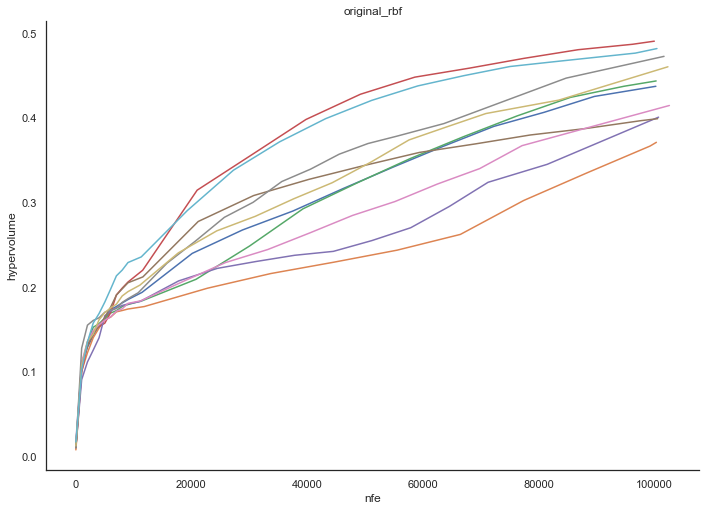

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
rbf = 'original_rbf'

fig, ax = plt.subplots(sharex=True)
for i in nfe_sets_all:
    ax.plot(nfe_sets_all[i], hv_sets_all[i])

ax.set_xlabel('nfe')
ax.set_ylabel('hypervolume')
ax.set_title(rbf)
sns.despine()

plt.show()

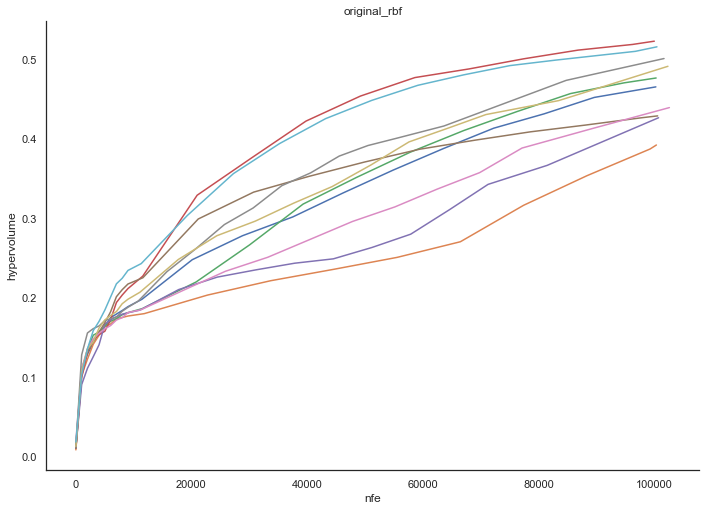

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")

dft_hv = pd.read_csv(f"hv/{rbf}_hv.csv")
dft_nfe = pd.read_csv(f"hv/{rbf}_hv_nfe.csv")

fig, ax = plt.subplots()

ax.plot(dft_nfe, dft_hv)
ax.set_xlabel('nfe')
ax.set_ylabel('hypervolume')
ax.set_title(rbf)
sns.despine()

plt.show()

In [76]:
ep_nfe = {}
ep_improv = {}
output_dir = f"../output/{rbf}/"
for i in os.listdir(output_dir):
    if i.endswith("_convergence.csv"):
        ep_load = pd.read_csv(output_dir + i)
        ep_nfe[int(i.split("_")[0])] = ep_load.nfe
        ep_improv[int(i.split("_")[0])]  = ep_load.improvements
ep_nfe = pd.DataFrame.from_dict(ep_nfe)
ep_improv = pd.DataFrame.from_dict(ep_improv)

# e_progress = pd.read_csv(output_dir + '10_convergence.csv')

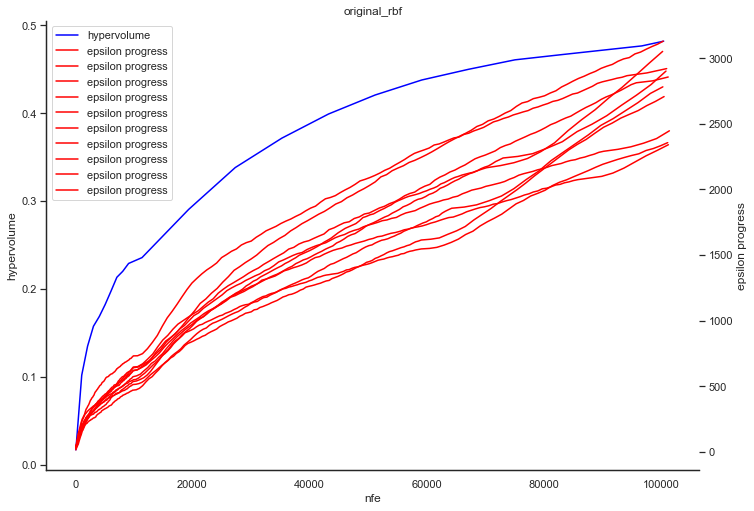

In [82]:
sns.set_style("white")

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(nfes, hvs, color= "blue", label="hypervolume")
ax2.plot(ep_nfe, ep_improv, color='red', label="epsilon progress")
ax.set_xlabel('nfe')
ax.set_ylabel('hypervolume')
ax2.set_ylabel('epsilon progress')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.set_title(rbf)
sns.despine()

plt.show()